# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

"\nDON'T MODIFY ANYTHING IN THIS CELL\n"

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

"\nDON'T MODIFY ANYTHING IN THIS CELL\n"

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

"\nDON'T MODIFY ANYTHING IN THIS CELL\n"

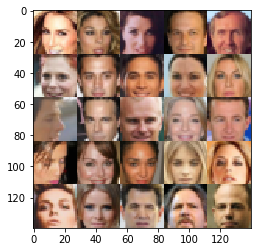

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

"\nDON'T MODIFY ANYTHING IN THIS CELL\n"

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name= 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name = 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    def conv_layers(inputs, nb_filter, filter_size, stride_size, batch_normalization = False, leaky_alpha = 0.1):
        outputs = tf.layers.conv2d(inputs, nb_filter, filter_size, stride_size, 'same')
        if batch_normalization == True:
            outputs = tf.layers.batch_normalization(outputs, training = True)
        leaky_outputs = tf.maximum(leaky_alpha*outputs, outputs)
        return leaky_outputs
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # inputs size 28*28*3
        x1 = conv_layers(images, 64, 5, 2, batch_normalization = False, leaky_alpha = 0.1)
        # x1 size 14*14*64
        
        x2 = conv_layers(x1, 128, 5, 2, batch_normalization = True, leaky_alpha = 0.1)
        # x2 size 7*7*128
        
        x3 = conv_layers(x2, 256, 5, 2, batch_normalization = True, leaky_alpha = 0.1)
        #x3 size 4*4*256
        
        flatten = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        outputs_sigmoid = tf.sigmoid(logits)
        

    return outputs_sigmoid, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    leaky_alpha = 0.1
    with tf.variable_scope("generator", reuse = not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(leaky_alpha*x1, x1)
        # x1 size 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, 'same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(leaky_alpha * x2, x2)
        #x2 size 14*14*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(leaky_alpha * x3, x3)
        # x3 size 28*28*128
        
        x3 = tf.nn.dropout(x3, 0.5)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 1, padding='same')
        outputs = tf.tanh(logits)
    
    return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_outputs = generator(input_z, out_channel_dim)
    d_outputs_real, d_logits_real = discriminator(input_real)
    d_outputs_fake, d_logits_fake = discriminator(g_outputs, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real * smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                        labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                   labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

"\nDON'T MODIFY ANYTHING IN THIS CELL\n"

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                step += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                d = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                g = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                if step % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

Epoch 1/2... Generator Loss: 21.3624 Discriminator Loss: 0.0075...
Epoch 1/2... Generator Loss: 14.4132 Discriminator Loss: 0.0005...
Epoch 1/2... Generator Loss: 11.1751 Discriminator Loss: 0.0007...
Epoch 1/2... Generator Loss: 13.0670 Discriminator Loss: 0.0008...
Epoch 1/2... Generator Loss: 11.2500 Discriminator Loss: 0.0017...
Epoch 1/2... Generator Loss: 9.4688 Discriminator Loss: 0.0002...
Epoch 1/2... Generator Loss: 9.1106 Discriminator Loss: 0.0015...
Epoch 1/2... Generator Loss: 9.0399 Discriminator Loss: 0.0005...
Epoch 1/2... Generator Loss: 7.6795 Discriminator Loss: 0.0010...
Epoch 1/2... Generator Loss: 10.0534 Discriminator Loss: 0.0004...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 7.9647 Discriminator Loss: 0.0005...
Epoch 1/2... Generator Loss: 18.6683 Discriminator Loss: 0.0003...
Epoch 1/2... Generator Loss: 7.6329 Discriminator Loss: 0.0011...
Epoch 1/2... Generator Loss: 8.0104 Discriminator Loss: 0.0007...
Epoch 1/2... Generator Loss: 8.6821 Discriminator Loss: 0.0003...
Epoch 1/2... Generator Loss: 6.9931 Discriminator Loss: 0.0018...
Epoch 1/2... Generator Loss: 8.9410 Discriminator Loss: 0.0007...
Epoch 1/2... Generator Loss: 8.9821 Discriminator Loss: 0.0004...
Epoch 1/2... Generator Loss: 9.2888 Discriminator Loss: 0.0004...
Epoch 1/2... Generator Loss: 9.4637 Discriminator Loss: 0.0002...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 7.0778 Discriminator Loss: 0.0234...
Epoch 1/2... Generator Loss: 28.1493 Discriminator Loss: 0.0079...
Epoch 1/2... Generator Loss: 21.8524 Discriminator Loss: 0.0035...
Epoch 1/2... Generator Loss: 4.3928 Discriminator Loss: 0.4568...
Epoch 1/2... Generator Loss: 3.8645 Discriminator Loss: 0.1312...
Epoch 1/2... Generator Loss: 1.4087 Discriminator Loss: 0.8462...
Epoch 1/2... Generator Loss: 1.8685 Discriminator Loss: 0.3410...
Epoch 1/2... Generator Loss: 1.1217 Discriminator Loss: 0.6392...
Epoch 1/2... Generator Loss: 2.9933 Discriminator Loss: 0.3046...
Epoch 1/2... Generator Loss: 0.8571 Discriminator Loss: 1.0968...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 1.6258 Discriminator Loss: 0.4503...
Epoch 1/2... Generator Loss: 0.8023 Discriminator Loss: 1.2012...
Epoch 1/2... Generator Loss: 1.9681 Discriminator Loss: 0.8020...
Epoch 1/2... Generator Loss: 0.5134 Discriminator Loss: 1.0429...
Epoch 1/2... Generator Loss: 5.3076 Discriminator Loss: 2.4164...
Epoch 1/2... Generator Loss: 0.6291 Discriminator Loss: 0.9909...
Epoch 1/2... Generator Loss: 4.2549 Discriminator Loss: 0.3877...
Epoch 1/2... Generator Loss: 0.8628 Discriminator Loss: 0.9802...
Epoch 1/2... Generator Loss: 0.3665 Discriminator Loss: 1.6384...
Epoch 1/2... Generator Loss: 0.2868 Discriminator Loss: 1.8607...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 2.5724 Discriminator Loss: 0.2272...
Epoch 1/2... Generator Loss: 1.1704 Discriminator Loss: 0.6258...
Epoch 1/2... Generator Loss: 3.6245 Discriminator Loss: 0.4359...
Epoch 1/2... Generator Loss: 1.2028 Discriminator Loss: 0.6841...
Epoch 1/2... Generator Loss: 1.5714 Discriminator Loss: 0.4828...
Epoch 1/2... Generator Loss: 1.2160 Discriminator Loss: 1.0264...
Epoch 1/2... Generator Loss: 0.8072 Discriminator Loss: 1.0523...
Epoch 1/2... Generator Loss: 0.8730 Discriminator Loss: 1.1731...
Epoch 1/2... Generator Loss: 2.1306 Discriminator Loss: 0.3675...
Epoch 1/2... Generator Loss: 1.6234 Discriminator Loss: 0.4203...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 2.2824 Discriminator Loss: 0.3917...
Epoch 1/2... Generator Loss: 0.2053 Discriminator Loss: 2.2672...
Epoch 1/2... Generator Loss: 2.9284 Discriminator Loss: 1.7875...
Epoch 1/2... Generator Loss: 0.9286 Discriminator Loss: 0.8881...
Epoch 1/2... Generator Loss: 0.4316 Discriminator Loss: 1.3218...
Epoch 1/2... Generator Loss: 1.3133 Discriminator Loss: 0.9046...
Epoch 1/2... Generator Loss: 1.4247 Discriminator Loss: 0.9890...
Epoch 1/2... Generator Loss: 1.0358 Discriminator Loss: 0.8513...
Epoch 1/2... Generator Loss: 0.8010 Discriminator Loss: 1.0196...
Epoch 1/2... Generator Loss: 3.1358 Discriminator Loss: 1.4332...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 0.5416 Discriminator Loss: 1.2723...
Epoch 1/2... Generator Loss: 2.0051 Discriminator Loss: 1.1929...
Epoch 1/2... Generator Loss: 1.1025 Discriminator Loss: 0.9370...
Epoch 1/2... Generator Loss: 1.7855 Discriminator Loss: 1.2237...
Epoch 1/2... Generator Loss: 0.5397 Discriminator Loss: 1.3268...
Epoch 1/2... Generator Loss: 0.5360 Discriminator Loss: 1.1780...
Epoch 1/2... Generator Loss: 0.8863 Discriminator Loss: 0.9966...
Epoch 1/2... Generator Loss: 0.4543 Discriminator Loss: 1.2911...
Epoch 1/2... Generator Loss: 1.4697 Discriminator Loss: 0.9797...
Epoch 1/2... Generator Loss: 0.4087 Discriminator Loss: 1.5657...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 0.8765 Discriminator Loss: 0.9281...
Epoch 1/2... Generator Loss: 0.6677 Discriminator Loss: 1.1461...
Epoch 1/2... Generator Loss: 1.9757 Discriminator Loss: 1.1813...
Epoch 1/2... Generator Loss: 1.4378 Discriminator Loss: 0.7701...
Epoch 1/2... Generator Loss: 2.5179 Discriminator Loss: 1.0970...
Epoch 1/2... Generator Loss: 0.9644 Discriminator Loss: 0.8956...
Epoch 1/2... Generator Loss: 2.0590 Discriminator Loss: 1.1258...
Epoch 1/2... Generator Loss: 0.8115 Discriminator Loss: 1.0868...
Epoch 1/2... Generator Loss: 0.3631 Discriminator Loss: 1.5262...
Epoch 1/2... Generator Loss: 1.1608 Discriminator Loss: 0.8881...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 1.2158 Discriminator Loss: 0.9875...
Epoch 1/2... Generator Loss: 1.2113 Discriminator Loss: 0.8196...
Epoch 1/2... Generator Loss: 0.4897 Discriminator Loss: 1.3047...
Epoch 1/2... Generator Loss: 0.8219 Discriminator Loss: 0.9137...
Epoch 1/2... Generator Loss: 1.5568 Discriminator Loss: 0.7684...
Epoch 1/2... Generator Loss: 0.5986 Discriminator Loss: 1.5038...
Epoch 1/2... Generator Loss: 0.6793 Discriminator Loss: 1.2924...
Epoch 1/2... Generator Loss: 0.8092 Discriminator Loss: 0.8578...
Epoch 1/2... Generator Loss: 1.1523 Discriminator Loss: 0.8566...
Epoch 1/2... Generator Loss: 1.3958 Discriminator Loss: 0.7400...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Generator Loss: 0.9059 Discriminator Loss: 0.8952...
Epoch 1/2... Generator Loss: 1.6905 Discriminator Loss: 0.7666...
Epoch 1/2... Generator Loss: 0.7501 Discriminator Loss: 1.0659...
Epoch 2/2... Generator Loss: 1.6607 Discriminator Loss: 1.1331...
Epoch 2/2... Generator Loss: 0.7916 Discriminator Loss: 0.9891...
Epoch 2/2... Generator Loss: 0.7076 Discriminator Loss: 1.0595...
Epoch 2/2... Generator Loss: 1.1754 Discriminator Loss: 0.8237...
Epoch 2/2... Generator Loss: 0.7150 Discriminator Loss: 1.0915...
Epoch 2/2... Generator Loss: 0.5798 Discriminator Loss: 1.1950...
Epoch 2/2... Generator Loss: 1.0583 Discriminator Loss: 0.7787...
Epoch 2/2... Generator Loss: 1.1018 Discriminator Loss: 0.9880...
Epoch 2/2... Generator Loss: 1.1768 Discriminator Loss: 0.7538...
Epoch 2/2... Generator Loss: 1.1997 Discriminator Loss: 0.9158...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 0.9971 Discriminator Loss: 0.8927...
Epoch 2/2... Generator Loss: 0.7991 Discriminator Loss: 0.9033...
Epoch 2/2... Generator Loss: 2.1742 Discriminator Loss: 0.7391...
Epoch 2/2... Generator Loss: 0.7639 Discriminator Loss: 1.0806...
Epoch 2/2... Generator Loss: 0.4307 Discriminator Loss: 1.5437...
Epoch 2/2... Generator Loss: 0.6367 Discriminator Loss: 1.0046...
Epoch 2/2... Generator Loss: 0.6220 Discriminator Loss: 1.0556...
Epoch 2/2... Generator Loss: 0.7501 Discriminator Loss: 1.0553...
Epoch 2/2... Generator Loss: 1.1470 Discriminator Loss: 0.8670...
Epoch 2/2... Generator Loss: 1.1330 Discriminator Loss: 0.7350...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.4041 Discriminator Loss: 0.7548...
Epoch 2/2... Generator Loss: 0.8955 Discriminator Loss: 0.8658...
Epoch 2/2... Generator Loss: 1.7632 Discriminator Loss: 0.7495...
Epoch 2/2... Generator Loss: 0.6799 Discriminator Loss: 1.0097...
Epoch 2/2... Generator Loss: 0.6096 Discriminator Loss: 1.0462...
Epoch 2/2... Generator Loss: 0.6717 Discriminator Loss: 1.0387...
Epoch 2/2... Generator Loss: 1.9724 Discriminator Loss: 0.7233...
Epoch 2/2... Generator Loss: 0.3749 Discriminator Loss: 1.5705...
Epoch 2/2... Generator Loss: 0.5838 Discriminator Loss: 1.0223...
Epoch 2/2... Generator Loss: 0.9172 Discriminator Loss: 0.9474...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.1202 Discriminator Loss: 0.7181...
Epoch 2/2... Generator Loss: 0.3813 Discriminator Loss: 1.6207...
Epoch 2/2... Generator Loss: 1.5578 Discriminator Loss: 0.8261...
Epoch 2/2... Generator Loss: 0.6683 Discriminator Loss: 1.0387...
Epoch 2/2... Generator Loss: 1.1381 Discriminator Loss: 0.6980...
Epoch 2/2... Generator Loss: 0.7158 Discriminator Loss: 0.9068...
Epoch 2/2... Generator Loss: 0.5255 Discriminator Loss: 1.2664...
Epoch 2/2... Generator Loss: 1.3857 Discriminator Loss: 0.6466...
Epoch 2/2... Generator Loss: 0.7720 Discriminator Loss: 1.1812...
Epoch 2/2... Generator Loss: 0.7698 Discriminator Loss: 0.9830...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 2.4657 Discriminator Loss: 0.7177...
Epoch 2/2... Generator Loss: 0.9155 Discriminator Loss: 0.8905...
Epoch 2/2... Generator Loss: 0.6657 Discriminator Loss: 1.0377...
Epoch 2/2... Generator Loss: 0.5850 Discriminator Loss: 1.2389...
Epoch 2/2... Generator Loss: 1.7995 Discriminator Loss: 0.4351...
Epoch 2/2... Generator Loss: 0.0481 Discriminator Loss: 3.5284...
Epoch 2/2... Generator Loss: 0.6927 Discriminator Loss: 1.0366...
Epoch 2/2... Generator Loss: 1.1334 Discriminator Loss: 0.7329...
Epoch 2/2... Generator Loss: 1.4483 Discriminator Loss: 0.7193...
Epoch 2/2... Generator Loss: 1.3042 Discriminator Loss: 0.6396...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 3.0446 Discriminator Loss: 2.0806...
Epoch 2/2... Generator Loss: 1.2185 Discriminator Loss: 0.8321...
Epoch 2/2... Generator Loss: 1.8635 Discriminator Loss: 0.8605...
Epoch 2/2... Generator Loss: 1.9271 Discriminator Loss: 0.6340...
Epoch 2/2... Generator Loss: 0.6077 Discriminator Loss: 1.0681...
Epoch 2/2... Generator Loss: 1.7264 Discriminator Loss: 0.7154...
Epoch 2/2... Generator Loss: 0.6691 Discriminator Loss: 1.1594...
Epoch 2/2... Generator Loss: 0.7471 Discriminator Loss: 1.0262...
Epoch 2/2... Generator Loss: 0.3815 Discriminator Loss: 1.5758...
Epoch 2/2... Generator Loss: 0.9787 Discriminator Loss: 0.7763...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.0097 Discriminator Loss: 0.8254...
Epoch 2/2... Generator Loss: 0.6038 Discriminator Loss: 1.1441...
Epoch 2/2... Generator Loss: 0.7785 Discriminator Loss: 0.9589...
Epoch 2/2... Generator Loss: 1.3455 Discriminator Loss: 0.6257...
Epoch 2/2... Generator Loss: 1.0026 Discriminator Loss: 1.2169...
Epoch 2/2... Generator Loss: 1.4340 Discriminator Loss: 0.6029...
Epoch 2/2... Generator Loss: 0.7887 Discriminator Loss: 0.8533...
Epoch 2/2... Generator Loss: 0.6463 Discriminator Loss: 1.1635...
Epoch 2/2... Generator Loss: 0.7596 Discriminator Loss: 0.9355...
Epoch 2/2... Generator Loss: 0.9812 Discriminator Loss: 0.7731...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.1182 Discriminator Loss: 0.6770...
Epoch 2/2... Generator Loss: 0.8916 Discriminator Loss: 0.7728...
Epoch 2/2... Generator Loss: 4.3796 Discriminator Loss: 1.2897...
Epoch 2/2... Generator Loss: 1.2874 Discriminator Loss: 0.5796...
Epoch 2/2... Generator Loss: 1.0430 Discriminator Loss: 0.9115...
Epoch 2/2... Generator Loss: 0.8940 Discriminator Loss: 0.7135...
Epoch 2/2... Generator Loss: 2.3903 Discriminator Loss: 0.7385...
Epoch 2/2... Generator Loss: 0.3678 Discriminator Loss: 1.6572...
Epoch 2/2... Generator Loss: 1.2609 Discriminator Loss: 0.7913...
Epoch 2/2... Generator Loss: 0.4162 Discriminator Loss: 1.4140...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.3086 Discriminator Loss: 0.5755...
Epoch 2/2... Generator Loss: 0.6576 Discriminator Loss: 1.2429...
Epoch 2/2... Generator Loss: 1.2959 Discriminator Loss: 0.9107...
Epoch 2/2... Generator Loss: 1.6668 Discriminator Loss: 0.5162...
Epoch 2/2... Generator Loss: 1.3932 Discriminator Loss: 0.6726...
Epoch 2/2... Generator Loss: 1.1857 Discriminator Loss: 0.8768...
Epoch 2/2... Generator Loss: 1.0694 Discriminator Loss: 1.0380...
Epoch 2/2... Generator Loss: 0.8420 Discriminator Loss: 0.8679...
Epoch 2/2... Generator Loss: 1.5078 Discriminator Loss: 0.6746...
Epoch 2/2... Generator Loss: 1.4327 Discriminator Loss: 0.5576...


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Generator Loss: 1.2682 Discriminator Loss: 0.5634...
Epoch 2/2... Generator Loss: 1.0137 Discriminator Loss: 0.7904...
Epoch 2/2... Generator Loss: 1.0451 Discriminator Loss: 0.7886...


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

Epoch 1/1... Generator Loss: 1.7023 Discriminator Loss: 0.3401...
Epoch 1/1... Generator Loss: 2.6883 Discriminator Loss: 0.1655...
Epoch 1/1... Generator Loss: 2.9531 Discriminator Loss: 0.1508...
Epoch 1/1... Generator Loss: 2.4113 Discriminator Loss: 0.1824...
Epoch 1/1... Generator Loss: 3.1560 Discriminator Loss: 0.1573...
Epoch 1/1... Generator Loss: 3.1807 Discriminator Loss: 0.0956...
Epoch 1/1... Generator Loss: 2.5880 Discriminator Loss: 0.1667...
Epoch 1/1... Generator Loss: 2.0496 Discriminator Loss: 0.3128...
Epoch 1/1... Generator Loss: 2.9744 Discriminator Loss: 0.1415...
Epoch 1/1... Generator Loss: 3.0009 Discriminator Loss: 0.1288...


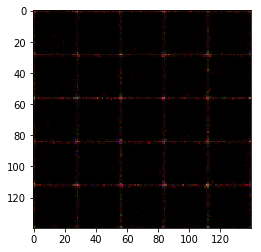

Epoch 1/1... Generator Loss: 2.8240 Discriminator Loss: 0.1371...
Epoch 1/1... Generator Loss: 3.9460 Discriminator Loss: 0.0468...
Epoch 1/1... Generator Loss: 4.0794 Discriminator Loss: 0.0416...
Epoch 1/1... Generator Loss: 3.7287 Discriminator Loss: 0.0695...
Epoch 1/1... Generator Loss: 2.9466 Discriminator Loss: 0.1008...
Epoch 1/1... Generator Loss: 3.6611 Discriminator Loss: 0.0563...
Epoch 1/1... Generator Loss: 6.0329 Discriminator Loss: 0.2037...
Epoch 1/1... Generator Loss: 2.6373 Discriminator Loss: 0.1738...
Epoch 1/1... Generator Loss: 3.5989 Discriminator Loss: 0.1105...
Epoch 1/1... Generator Loss: 2.6824 Discriminator Loss: 0.1470...


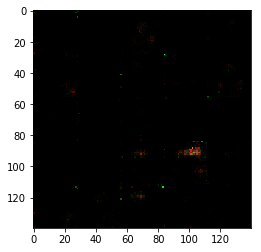

Epoch 1/1... Generator Loss: 3.5837 Discriminator Loss: 0.0779...
Epoch 1/1... Generator Loss: 3.3712 Discriminator Loss: 0.0680...
Epoch 1/1... Generator Loss: 3.7256 Discriminator Loss: 0.0968...
Epoch 1/1... Generator Loss: 3.1660 Discriminator Loss: 0.0980...
Epoch 1/1... Generator Loss: 3.0340 Discriminator Loss: 0.1062...
Epoch 1/1... Generator Loss: 2.7817 Discriminator Loss: 0.1332...
Epoch 1/1... Generator Loss: 2.4453 Discriminator Loss: 0.1671...
Epoch 1/1... Generator Loss: 2.8536 Discriminator Loss: 0.1034...
Epoch 1/1... Generator Loss: 3.3788 Discriminator Loss: 0.1027...
Epoch 1/1... Generator Loss: 2.4360 Discriminator Loss: 0.1339...


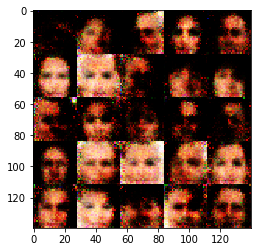

Epoch 1/1... Generator Loss: 3.3479 Discriminator Loss: 0.0829...
Epoch 1/1... Generator Loss: 2.8856 Discriminator Loss: 0.1219...
Epoch 1/1... Generator Loss: 4.3260 Discriminator Loss: 0.4618...
Epoch 1/1... Generator Loss: 2.4859 Discriminator Loss: 0.2170...
Epoch 1/1... Generator Loss: 2.3913 Discriminator Loss: 0.2368...
Epoch 1/1... Generator Loss: 2.1146 Discriminator Loss: 0.1910...
Epoch 1/1... Generator Loss: 3.3085 Discriminator Loss: 0.1373...
Epoch 1/1... Generator Loss: 4.1083 Discriminator Loss: 0.0991...
Epoch 1/1... Generator Loss: 3.8848 Discriminator Loss: 0.2447...
Epoch 1/1... Generator Loss: 2.2221 Discriminator Loss: 0.2087...


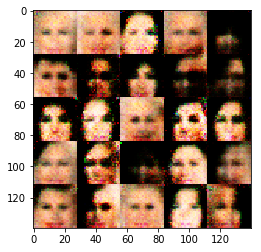

Epoch 1/1... Generator Loss: 3.1847 Discriminator Loss: 0.2569...
Epoch 1/1... Generator Loss: 2.8240 Discriminator Loss: 0.1853...
Epoch 1/1... Generator Loss: 2.5488 Discriminator Loss: 0.2022...
Epoch 1/1... Generator Loss: 2.1714 Discriminator Loss: 0.2051...
Epoch 1/1... Generator Loss: 7.1381 Discriminator Loss: 1.9507...
Epoch 1/1... Generator Loss: 3.4054 Discriminator Loss: 0.1806...
Epoch 1/1... Generator Loss: 1.9384 Discriminator Loss: 0.3269...
Epoch 1/1... Generator Loss: 3.0338 Discriminator Loss: 0.1876...
Epoch 1/1... Generator Loss: 4.8022 Discriminator Loss: 0.1853...
Epoch 1/1... Generator Loss: 3.7321 Discriminator Loss: 0.2239...


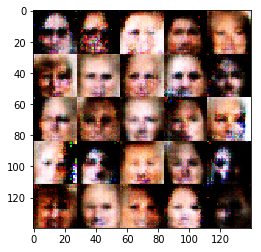

Epoch 1/1... Generator Loss: 2.4178 Discriminator Loss: 0.2902...
Epoch 1/1... Generator Loss: 2.5761 Discriminator Loss: 0.3599...
Epoch 1/1... Generator Loss: 5.5753 Discriminator Loss: 1.4537...
Epoch 1/1... Generator Loss: 1.8793 Discriminator Loss: 0.3567...
Epoch 1/1... Generator Loss: 1.7670 Discriminator Loss: 0.3694...
Epoch 1/1... Generator Loss: 3.1642 Discriminator Loss: 0.7616...
Epoch 1/1... Generator Loss: 1.1048 Discriminator Loss: 0.7054...
Epoch 1/1... Generator Loss: 1.8720 Discriminator Loss: 0.4128...
Epoch 1/1... Generator Loss: 1.2702 Discriminator Loss: 0.5904...
Epoch 1/1... Generator Loss: 1.6700 Discriminator Loss: 0.5029...


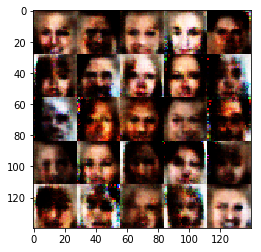

Epoch 1/1... Generator Loss: 1.6976 Discriminator Loss: 0.4586...
Epoch 1/1... Generator Loss: 2.1698 Discriminator Loss: 0.4535...
Epoch 1/1... Generator Loss: 1.3727 Discriminator Loss: 0.4908...
Epoch 1/1... Generator Loss: 3.5705 Discriminator Loss: 1.5319...
Epoch 1/1... Generator Loss: 1.1942 Discriminator Loss: 0.6259...
Epoch 1/1... Generator Loss: 1.4146 Discriminator Loss: 0.5500...
Epoch 1/1... Generator Loss: 2.6442 Discriminator Loss: 0.7126...
Epoch 1/1... Generator Loss: 2.3322 Discriminator Loss: 0.7730...
Epoch 1/1... Generator Loss: 1.6736 Discriminator Loss: 0.7166...
Epoch 1/1... Generator Loss: 2.9196 Discriminator Loss: 1.1143...


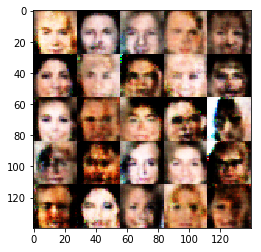

Epoch 1/1... Generator Loss: 0.7827 Discriminator Loss: 1.0198...
Epoch 1/1... Generator Loss: 1.5183 Discriminator Loss: 0.5947...
Epoch 1/1... Generator Loss: 1.5295 Discriminator Loss: 0.5472...
Epoch 1/1... Generator Loss: 1.9373 Discriminator Loss: 0.4210...
Epoch 1/1... Generator Loss: 1.2995 Discriminator Loss: 0.6088...
Epoch 1/1... Generator Loss: 2.4788 Discriminator Loss: 0.5402...
Epoch 1/1... Generator Loss: 1.6522 Discriminator Loss: 0.6269...
Epoch 1/1... Generator Loss: 1.4967 Discriminator Loss: 0.5662...
Epoch 1/1... Generator Loss: 1.0623 Discriminator Loss: 0.7331...
Epoch 1/1... Generator Loss: 1.0312 Discriminator Loss: 0.7136...


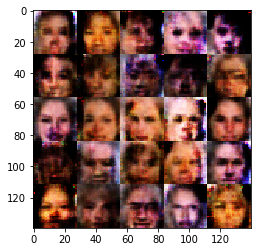

Epoch 1/1... Generator Loss: 0.9058 Discriminator Loss: 0.7996...
Epoch 1/1... Generator Loss: 0.8481 Discriminator Loss: 0.8316...
Epoch 1/1... Generator Loss: 1.1834 Discriminator Loss: 0.7522...
Epoch 1/1... Generator Loss: 1.4348 Discriminator Loss: 0.5421...
Epoch 1/1... Generator Loss: 2.9195 Discriminator Loss: 1.3812...
Epoch 1/1... Generator Loss: 1.2425 Discriminator Loss: 0.7528...
Epoch 1/1... Generator Loss: 2.5655 Discriminator Loss: 0.9061...
Epoch 1/1... Generator Loss: 0.4736 Discriminator Loss: 1.2106...
Epoch 1/1... Generator Loss: 1.7530 Discriminator Loss: 0.9120...
Epoch 1/1... Generator Loss: 0.5244 Discriminator Loss: 1.2170...


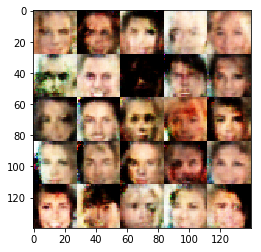

Epoch 1/1... Generator Loss: 1.6195 Discriminator Loss: 0.5620...
Epoch 1/1... Generator Loss: 1.2538 Discriminator Loss: 1.0381...
Epoch 1/1... Generator Loss: 1.0729 Discriminator Loss: 0.7552...
Epoch 1/1... Generator Loss: 1.4052 Discriminator Loss: 0.8063...
Epoch 1/1... Generator Loss: 1.4704 Discriminator Loss: 0.7304...
Epoch 1/1... Generator Loss: 0.5539 Discriminator Loss: 1.2406...
Epoch 1/1... Generator Loss: 1.9459 Discriminator Loss: 0.6978...
Epoch 1/1... Generator Loss: 0.8071 Discriminator Loss: 0.9131...
Epoch 1/1... Generator Loss: 1.4266 Discriminator Loss: 0.7477...
Epoch 1/1... Generator Loss: 1.5375 Discriminator Loss: 0.8461...


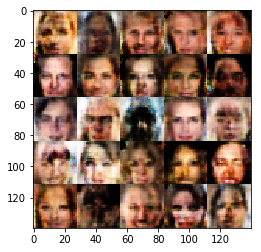

Epoch 1/1... Generator Loss: 1.3363 Discriminator Loss: 0.7897...
Epoch 1/1... Generator Loss: 0.7230 Discriminator Loss: 0.9769...
Epoch 1/1... Generator Loss: 1.8128 Discriminator Loss: 1.4500...
Epoch 1/1... Generator Loss: 1.7806 Discriminator Loss: 0.7994...
Epoch 1/1... Generator Loss: 1.0258 Discriminator Loss: 0.7284...
Epoch 1/1... Generator Loss: 0.9033 Discriminator Loss: 0.8584...
Epoch 1/1... Generator Loss: 1.0120 Discriminator Loss: 0.8345...
Epoch 1/1... Generator Loss: 1.0513 Discriminator Loss: 0.7622...
Epoch 1/1... Generator Loss: 0.4923 Discriminator Loss: 1.2432...
Epoch 1/1... Generator Loss: 1.0867 Discriminator Loss: 0.8696...


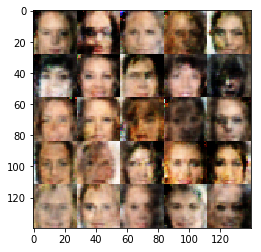

Epoch 1/1... Generator Loss: 1.0773 Discriminator Loss: 0.8694...
Epoch 1/1... Generator Loss: 1.4799 Discriminator Loss: 0.8947...
Epoch 1/1... Generator Loss: 0.7800 Discriminator Loss: 0.9691...
Epoch 1/1... Generator Loss: 1.1041 Discriminator Loss: 0.8041...
Epoch 1/1... Generator Loss: 1.2512 Discriminator Loss: 0.9440...
Epoch 1/1... Generator Loss: 0.7900 Discriminator Loss: 0.9545...
Epoch 1/1... Generator Loss: 1.1218 Discriminator Loss: 0.9734...
Epoch 1/1... Generator Loss: 0.7820 Discriminator Loss: 1.1021...
Epoch 1/1... Generator Loss: 1.1204 Discriminator Loss: 0.9027...
Epoch 1/1... Generator Loss: 0.9228 Discriminator Loss: 0.9269...


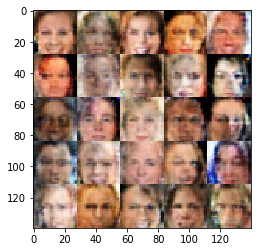

Epoch 1/1... Generator Loss: 0.7006 Discriminator Loss: 1.1235...
Epoch 1/1... Generator Loss: 0.9089 Discriminator Loss: 0.9432...
Epoch 1/1... Generator Loss: 1.3057 Discriminator Loss: 0.8629...
Epoch 1/1... Generator Loss: 1.2810 Discriminator Loss: 0.7996...
Epoch 1/1... Generator Loss: 1.1230 Discriminator Loss: 1.0845...
Epoch 1/1... Generator Loss: 0.6677 Discriminator Loss: 1.1709...
Epoch 1/1... Generator Loss: 1.2304 Discriminator Loss: 0.8223...
Epoch 1/1... Generator Loss: 1.0425 Discriminator Loss: 0.9603...
Epoch 1/1... Generator Loss: 0.8480 Discriminator Loss: 0.9905...
Epoch 1/1... Generator Loss: 0.9334 Discriminator Loss: 0.9843...


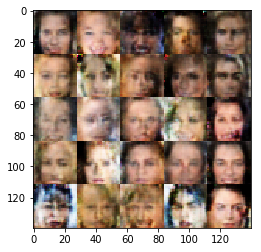

Epoch 1/1... Generator Loss: 0.5154 Discriminator Loss: 1.2399...
Epoch 1/1... Generator Loss: 0.9061 Discriminator Loss: 1.0581...
Epoch 1/1... Generator Loss: 1.2225 Discriminator Loss: 0.9161...
Epoch 1/1... Generator Loss: 0.9263 Discriminator Loss: 0.9381...
Epoch 1/1... Generator Loss: 0.9141 Discriminator Loss: 0.9772...
Epoch 1/1... Generator Loss: 0.9075 Discriminator Loss: 1.0307...
Epoch 1/1... Generator Loss: 1.0217 Discriminator Loss: 0.9379...
Epoch 1/1... Generator Loss: 0.7325 Discriminator Loss: 1.0598...
Epoch 1/1... Generator Loss: 1.0020 Discriminator Loss: 1.0236...
Epoch 1/1... Generator Loss: 1.2295 Discriminator Loss: 0.9856...


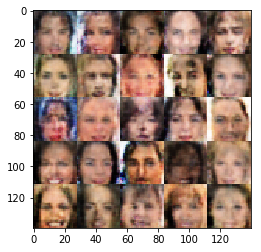

Epoch 1/1... Generator Loss: 0.9727 Discriminator Loss: 0.8846...
Epoch 1/1... Generator Loss: 1.0429 Discriminator Loss: 1.1251...
Epoch 1/1... Generator Loss: 0.9988 Discriminator Loss: 1.0867...
Epoch 1/1... Generator Loss: 0.7415 Discriminator Loss: 1.0844...
Epoch 1/1... Generator Loss: 0.9768 Discriminator Loss: 1.0016...
Epoch 1/1... Generator Loss: 0.9231 Discriminator Loss: 1.1028...
Epoch 1/1... Generator Loss: 1.1812 Discriminator Loss: 0.8964...
Epoch 1/1... Generator Loss: 0.5882 Discriminator Loss: 1.0790...
Epoch 1/1... Generator Loss: 1.2369 Discriminator Loss: 0.8367...
Epoch 1/1... Generator Loss: 0.6804 Discriminator Loss: 1.0730...


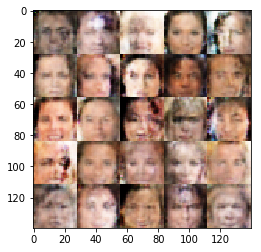

Epoch 1/1... Generator Loss: 1.1145 Discriminator Loss: 1.1245...
Epoch 1/1... Generator Loss: 0.8231 Discriminator Loss: 0.9975...
Epoch 1/1... Generator Loss: 0.9897 Discriminator Loss: 0.8249...
Epoch 1/1... Generator Loss: 0.9737 Discriminator Loss: 1.0543...
Epoch 1/1... Generator Loss: 0.7769 Discriminator Loss: 0.9977...
Epoch 1/1... Generator Loss: 1.2206 Discriminator Loss: 0.9544...
Epoch 1/1... Generator Loss: 0.9201 Discriminator Loss: 1.0416...
Epoch 1/1... Generator Loss: 1.1312 Discriminator Loss: 0.8699...
Epoch 1/1... Generator Loss: 0.8217 Discriminator Loss: 1.1555...
Epoch 1/1... Generator Loss: 1.0135 Discriminator Loss: 0.9854...


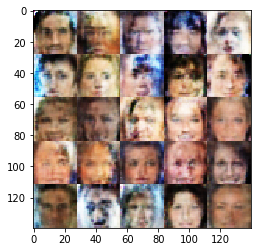

Epoch 1/1... Generator Loss: 0.9234 Discriminator Loss: 1.0758...
Epoch 1/1... Generator Loss: 0.8247 Discriminator Loss: 1.0391...
Epoch 1/1... Generator Loss: 0.7550 Discriminator Loss: 1.0922...
Epoch 1/1... Generator Loss: 0.8350 Discriminator Loss: 1.0882...
Epoch 1/1... Generator Loss: 1.0039 Discriminator Loss: 0.8949...
Epoch 1/1... Generator Loss: 0.8024 Discriminator Loss: 1.0259...
Epoch 1/1... Generator Loss: 0.9675 Discriminator Loss: 1.0248...
Epoch 1/1... Generator Loss: 1.1096 Discriminator Loss: 1.0577...
Epoch 1/1... Generator Loss: 0.5821 Discriminator Loss: 1.2542...
Epoch 1/1... Generator Loss: 0.9302 Discriminator Loss: 1.1249...


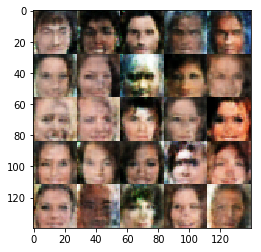

Epoch 1/1... Generator Loss: 0.9652 Discriminator Loss: 0.8461...
Epoch 1/1... Generator Loss: 0.6222 Discriminator Loss: 1.2632...
Epoch 1/1... Generator Loss: 0.8126 Discriminator Loss: 1.0935...
Epoch 1/1... Generator Loss: 0.7439 Discriminator Loss: 1.1368...
Epoch 1/1... Generator Loss: 0.8316 Discriminator Loss: 1.0467...
Epoch 1/1... Generator Loss: 1.1188 Discriminator Loss: 1.0403...
Epoch 1/1... Generator Loss: 1.0647 Discriminator Loss: 1.0559...
Epoch 1/1... Generator Loss: 0.6881 Discriminator Loss: 1.2012...
Epoch 1/1... Generator Loss: 0.6861 Discriminator Loss: 1.2220...
Epoch 1/1... Generator Loss: 0.8253 Discriminator Loss: 1.0174...


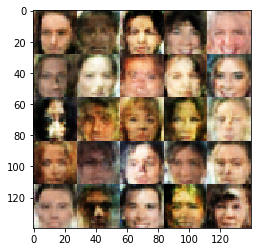

Epoch 1/1... Generator Loss: 0.7974 Discriminator Loss: 1.1483...
Epoch 1/1... Generator Loss: 0.8500 Discriminator Loss: 1.1673...
Epoch 1/1... Generator Loss: 1.0458 Discriminator Loss: 0.8639...
Epoch 1/1... Generator Loss: 0.7620 Discriminator Loss: 1.0726...
Epoch 1/1... Generator Loss: 0.8967 Discriminator Loss: 1.0248...
Epoch 1/1... Generator Loss: 0.8409 Discriminator Loss: 1.0380...
Epoch 1/1... Generator Loss: 0.5326 Discriminator Loss: 1.5029...
Epoch 1/1... Generator Loss: 0.9416 Discriminator Loss: 1.2047...
Epoch 1/1... Generator Loss: 1.0324 Discriminator Loss: 0.8571...
Epoch 1/1... Generator Loss: 0.4998 Discriminator Loss: 1.3404...


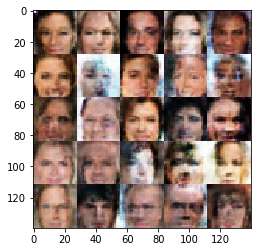

Epoch 1/1... Generator Loss: 0.7621 Discriminator Loss: 1.0786...
Epoch 1/1... Generator Loss: 0.6658 Discriminator Loss: 1.1137...
Epoch 1/1... Generator Loss: 0.5718 Discriminator Loss: 1.1716...
Epoch 1/1... Generator Loss: 1.0669 Discriminator Loss: 0.9404...
Epoch 1/1... Generator Loss: 0.7826 Discriminator Loss: 1.2141...
Epoch 1/1... Generator Loss: 0.9405 Discriminator Loss: 1.0497...
Epoch 1/1... Generator Loss: 0.6088 Discriminator Loss: 1.2964...
Epoch 1/1... Generator Loss: 0.7961 Discriminator Loss: 1.0095...
Epoch 1/1... Generator Loss: 0.7672 Discriminator Loss: 1.0683...
Epoch 1/1... Generator Loss: 0.9054 Discriminator Loss: 1.0402...


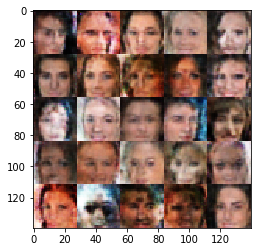

Epoch 1/1... Generator Loss: 0.7390 Discriminator Loss: 1.1727...
Epoch 1/1... Generator Loss: 1.0218 Discriminator Loss: 0.9720...
Epoch 1/1... Generator Loss: 1.1149 Discriminator Loss: 1.0149...
Epoch 1/1... Generator Loss: 0.6534 Discriminator Loss: 1.3127...
Epoch 1/1... Generator Loss: 0.8936 Discriminator Loss: 0.9179...
Epoch 1/1... Generator Loss: 0.9255 Discriminator Loss: 1.0370...
Epoch 1/1... Generator Loss: 0.7691 Discriminator Loss: 1.0874...
Epoch 1/1... Generator Loss: 0.8166 Discriminator Loss: 1.1127...
Epoch 1/1... Generator Loss: 0.7034 Discriminator Loss: 1.1209...
Epoch 1/1... Generator Loss: 1.0477 Discriminator Loss: 0.8348...


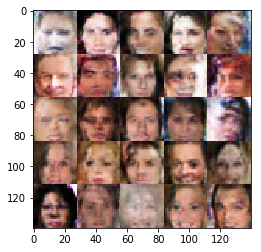

Epoch 1/1... Generator Loss: 0.6325 Discriminator Loss: 1.1742...
Epoch 1/1... Generator Loss: 0.7884 Discriminator Loss: 1.0557...
Epoch 1/1... Generator Loss: 0.7394 Discriminator Loss: 1.1583...
Epoch 1/1... Generator Loss: 0.6393 Discriminator Loss: 1.1688...
Epoch 1/1... Generator Loss: 0.8751 Discriminator Loss: 1.1277...
Epoch 1/1... Generator Loss: 0.7390 Discriminator Loss: 1.1655...
Epoch 1/1... Generator Loss: 1.1855 Discriminator Loss: 0.8764...
Epoch 1/1... Generator Loss: 1.2338 Discriminator Loss: 1.0906...
Epoch 1/1... Generator Loss: 0.8895 Discriminator Loss: 1.1412...
Epoch 1/1... Generator Loss: 0.9537 Discriminator Loss: 0.9948...


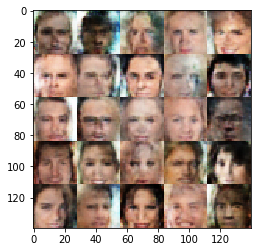

Epoch 1/1... Generator Loss: 0.7678 Discriminator Loss: 1.1323...
Epoch 1/1... Generator Loss: 0.7974 Discriminator Loss: 1.0937...
Epoch 1/1... Generator Loss: 0.8177 Discriminator Loss: 1.1850...
Epoch 1/1... Generator Loss: 0.5685 Discriminator Loss: 1.2428...
Epoch 1/1... Generator Loss: 0.8804 Discriminator Loss: 1.0455...
Epoch 1/1... Generator Loss: 0.8342 Discriminator Loss: 1.0878...
Epoch 1/1... Generator Loss: 0.9606 Discriminator Loss: 1.1711...
Epoch 1/1... Generator Loss: 0.5968 Discriminator Loss: 1.2945...
Epoch 1/1... Generator Loss: 0.8383 Discriminator Loss: 1.2157...
Epoch 1/1... Generator Loss: 1.1471 Discriminator Loss: 0.7490...


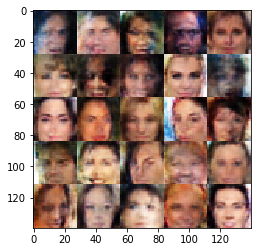

Epoch 1/1... Generator Loss: 0.8179 Discriminator Loss: 1.2020...
Epoch 1/1... Generator Loss: 0.8611 Discriminator Loss: 0.9992...
Epoch 1/1... Generator Loss: 0.9123 Discriminator Loss: 0.9070...
Epoch 1/1... Generator Loss: 0.7248 Discriminator Loss: 1.1652...
Epoch 1/1... Generator Loss: 0.8528 Discriminator Loss: 1.0186...
Epoch 1/1... Generator Loss: 1.0736 Discriminator Loss: 0.6824...
Epoch 1/1... Generator Loss: 0.6250 Discriminator Loss: 1.1355...
Epoch 1/1... Generator Loss: 0.8942 Discriminator Loss: 1.0806...
Epoch 1/1... Generator Loss: 1.0479 Discriminator Loss: 0.9048...
Epoch 1/1... Generator Loss: 0.7720 Discriminator Loss: 1.0669...


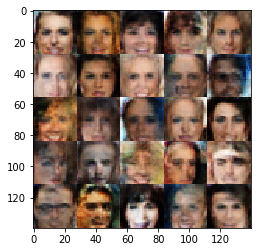

Epoch 1/1... Generator Loss: 0.9399 Discriminator Loss: 1.0110...
Epoch 1/1... Generator Loss: 0.8210 Discriminator Loss: 1.0084...
Epoch 1/1... Generator Loss: 0.7725 Discriminator Loss: 1.1111...
Epoch 1/1... Generator Loss: 0.8623 Discriminator Loss: 1.0248...
Epoch 1/1... Generator Loss: 1.0354 Discriminator Loss: 1.2370...
Epoch 1/1... Generator Loss: 0.7657 Discriminator Loss: 1.2044...
Epoch 1/1... Generator Loss: 0.6761 Discriminator Loss: 1.2148...
Epoch 1/1... Generator Loss: 0.9879 Discriminator Loss: 0.9502...
Epoch 1/1... Generator Loss: 1.2038 Discriminator Loss: 1.0267...
Epoch 1/1... Generator Loss: 0.7507 Discriminator Loss: 1.2517...


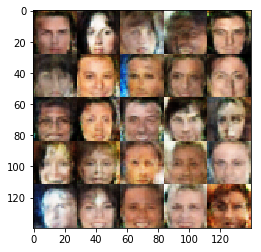

Epoch 1/1... Generator Loss: 0.9877 Discriminator Loss: 1.0307...
Epoch 1/1... Generator Loss: 0.7914 Discriminator Loss: 1.1632...
Epoch 1/1... Generator Loss: 0.9456 Discriminator Loss: 0.9505...
Epoch 1/1... Generator Loss: 0.6442 Discriminator Loss: 1.1049...
Epoch 1/1... Generator Loss: 0.7305 Discriminator Loss: 1.2036...
Epoch 1/1... Generator Loss: 0.6879 Discriminator Loss: 1.1599...
Epoch 1/1... Generator Loss: 0.7866 Discriminator Loss: 1.0152...
Epoch 1/1... Generator Loss: 0.9350 Discriminator Loss: 1.0104...
Epoch 1/1... Generator Loss: 0.7996 Discriminator Loss: 1.0805...
Epoch 1/1... Generator Loss: 0.5674 Discriminator Loss: 1.3195...


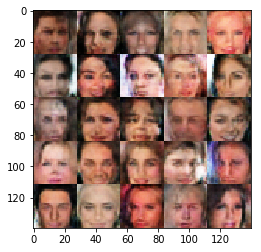

Epoch 1/1... Generator Loss: 1.0885 Discriminator Loss: 1.2194...
Epoch 1/1... Generator Loss: 0.7613 Discriminator Loss: 1.2080...
Epoch 1/1... Generator Loss: 0.6203 Discriminator Loss: 1.2872...
Epoch 1/1... Generator Loss: 0.7171 Discriminator Loss: 1.1207...
Epoch 1/1... Generator Loss: 0.9845 Discriminator Loss: 1.1694...
Epoch 1/1... Generator Loss: 1.0742 Discriminator Loss: 0.9467...
Epoch 1/1... Generator Loss: 0.5738 Discriminator Loss: 1.1944...
Epoch 1/1... Generator Loss: 0.7894 Discriminator Loss: 1.2017...
Epoch 1/1... Generator Loss: 0.7420 Discriminator Loss: 1.1937...
Epoch 1/1... Generator Loss: 1.0300 Discriminator Loss: 0.9431...


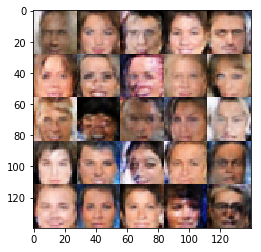

Epoch 1/1... Generator Loss: 0.8409 Discriminator Loss: 1.1468...
Epoch 1/1... Generator Loss: 0.6841 Discriminator Loss: 1.1279...
Epoch 1/1... Generator Loss: 0.6500 Discriminator Loss: 1.3075...
Epoch 1/1... Generator Loss: 0.9516 Discriminator Loss: 1.0316...
Epoch 1/1... Generator Loss: 0.6862 Discriminator Loss: 1.3081...
Epoch 1/1... Generator Loss: 0.8039 Discriminator Loss: 1.1223...
Epoch 1/1... Generator Loss: 0.8167 Discriminator Loss: 1.1216...
Epoch 1/1... Generator Loss: 0.7518 Discriminator Loss: 1.0918...
Epoch 1/1... Generator Loss: 0.7724 Discriminator Loss: 1.2130...
Epoch 1/1... Generator Loss: 0.9506 Discriminator Loss: 0.9074...


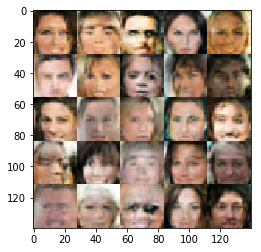

Epoch 1/1... Generator Loss: 0.4413 Discriminator Loss: 1.4322...
Epoch 1/1... Generator Loss: 0.8200 Discriminator Loss: 1.0500...
Epoch 1/1... Generator Loss: 0.7654 Discriminator Loss: 0.9692...
Epoch 1/1... Generator Loss: 0.5622 Discriminator Loss: 1.2996...
Epoch 1/1... Generator Loss: 0.9646 Discriminator Loss: 0.9915...
Epoch 1/1... Generator Loss: 1.0588 Discriminator Loss: 1.0082...
Epoch 1/1... Generator Loss: 0.6048 Discriminator Loss: 1.1847...
Epoch 1/1... Generator Loss: 0.8000 Discriminator Loss: 1.0758...
Epoch 1/1... Generator Loss: 0.7041 Discriminator Loss: 1.1297...
Epoch 1/1... Generator Loss: 0.8525 Discriminator Loss: 1.0870...


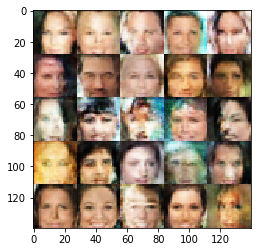

Epoch 1/1... Generator Loss: 0.6218 Discriminator Loss: 1.1201...
Epoch 1/1... Generator Loss: 0.7746 Discriminator Loss: 1.1100...
Epoch 1/1... Generator Loss: 0.9827 Discriminator Loss: 0.9922...
Epoch 1/1... Generator Loss: 0.6281 Discriminator Loss: 1.1996...
Epoch 1/1... Generator Loss: 0.7255 Discriminator Loss: 1.1797...
Epoch 1/1... Generator Loss: 0.8359 Discriminator Loss: 1.0683...
Epoch 1/1... Generator Loss: 0.7198 Discriminator Loss: 1.0760...
Epoch 1/1... Generator Loss: 0.7958 Discriminator Loss: 1.0797...
Epoch 1/1... Generator Loss: 0.8050 Discriminator Loss: 1.1700...
Epoch 1/1... Generator Loss: 0.5678 Discriminator Loss: 1.2420...


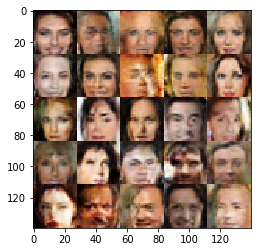

Epoch 1/1... Generator Loss: 1.0034 Discriminator Loss: 1.0661...
Epoch 1/1... Generator Loss: 0.7467 Discriminator Loss: 1.0722...
Epoch 1/1... Generator Loss: 0.9499 Discriminator Loss: 1.1496...
Epoch 1/1... Generator Loss: 0.6131 Discriminator Loss: 1.3542...
Epoch 1/1... Generator Loss: 1.0138 Discriminator Loss: 1.0257...
Epoch 1/1... Generator Loss: 0.6217 Discriminator Loss: 1.1778...
Epoch 1/1... Generator Loss: 0.8503 Discriminator Loss: 1.0922...
Epoch 1/1... Generator Loss: 1.3392 Discriminator Loss: 0.9730...
Epoch 1/1... Generator Loss: 0.7174 Discriminator Loss: 1.1525...
Epoch 1/1... Generator Loss: 0.5699 Discriminator Loss: 1.1522...


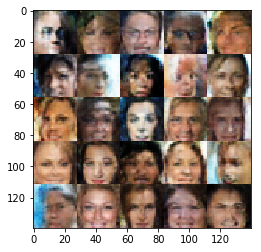

Epoch 1/1... Generator Loss: 0.6432 Discriminator Loss: 1.2338...
Epoch 1/1... Generator Loss: 0.8467 Discriminator Loss: 1.0822...
Epoch 1/1... Generator Loss: 0.9117 Discriminator Loss: 1.1449...
Epoch 1/1... Generator Loss: 1.0769 Discriminator Loss: 0.8661...
Epoch 1/1... Generator Loss: 0.7274 Discriminator Loss: 1.2334...
Epoch 1/1... Generator Loss: 0.4317 Discriminator Loss: 1.3427...


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.